In [1]:
# 1. Import packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn import plotting
import nibabel as nib

In [2]:

# 2. Set up paths (adjust based on your actual structure)
BASE_DIR = "F:/Programming codes/Machine Learning/Projects/brain-disease-segmentation-benchmark"
DATA_DIR = os.path.join(BASE_DIR, "data")
OASIS_DIR = os.path.join(DATA_DIR, "oasis1")
OASIS_CSV_PATH = os.path.join(OASIS_DIR, "oasis_cross-sectional.csv")


In [3]:
# Create necessary directories
PROCESSED_DIR = os.path.join(DATA_DIR, "processed")
RESULTS_DIR = os.path.join(BASE_DIR, "results")
os.makedirs(PROCESSED_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

print("Paths setup complete")
print(f"OASIS data directory: {OASIS_DIR}")
print(f"CSV file: {OASIS_CSV_PATH}")

Paths setup complete
OASIS data directory: F:/Programming codes/Machine Learning/Projects/brain-disease-segmentation-benchmark\data\oasis1
CSV file: F:/Programming codes/Machine Learning/Projects/brain-disease-segmentation-benchmark\data\oasis1\oasis_cross-sectional.csv


In [6]:
# 3. Load and explore metadata
print("\n" + "="*60)
print("METADATA EXPLORATION")
print("="*60)


# Load the CSV file
df = pd.read_csv(OASIS_CSV_PATH)
print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")


# Display first few rows
print("\nFirst 5 rows:")
print(df.head())

# Basic information
print("\nDataset info:")
print(df.info())


METADATA EXPLORATION
Dataset shape: (436, 12)
Columns: ['ID', 'M/F', 'Hand', 'Age', 'Educ', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF', 'Delay']

First 5 rows:
              ID M/F Hand  Age  Educ  SES  MMSE  CDR  eTIV   nWBV    ASF  \
0  OAS1_0001_MR1   F    R   74   2.0  3.0  29.0  0.0  1344  0.743  1.306   
1  OAS1_0002_MR1   F    R   55   4.0  1.0  29.0  0.0  1147  0.810  1.531   
2  OAS1_0003_MR1   F    R   73   4.0  3.0  27.0  0.5  1454  0.708  1.207   
3  OAS1_0004_MR1   M    R   28   NaN  NaN   NaN  NaN  1588  0.803  1.105   
4  OAS1_0005_MR1   M    R   18   NaN  NaN   NaN  NaN  1737  0.848  1.010   

   Delay  
0    NaN  
1    NaN  
2    NaN  
3    NaN  
4    NaN  

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 436 entries, 0 to 435
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      436 non-null    object 
 1   M/F     436 non-null    object 
 2   Hand    436 non-null    object 
 3   Age  

<!-- Column Descriptions in OASIS CSV
Column	Meaning
ID	Unique subject identifier
M/F	Gender: Male (M) or Female (F)
Hand	Handedness: typically 'R' for right-handed (all subjects in OASIS-1 are right-handed)
Age	Age of the subject in years
Educ	Years of education completed
SES	Socioeconomic status (1–5 scale, based on Hollingshead Index)
MMSE	Mini-Mental State Examination score (0–30, cognitive assessment)
CDR	Clinical Dementia Rating (0 = no dementia, 0.5 = very mild, 1 = mild, etc.)
eTIV	Estimated Total Intracranial Volume (from FreeSurfer)
nWBV	Normalized Whole Brain Volume (ratio of brain volume to eTIV)
ASF	    Atlas Scaling Factor (used for spatial normalization in imaging) -->

In [7]:
# 4. Basic data cleaning and preparation
# Rename columns for easier access
df = df.rename(columns={'M/F': 'Gender', 'Educ': 'Education', 'eTIV': 'TIV', 'nWBV': 'WBV'})

# Convert to appropriate data types
df['CDR'] = pd.to_numeric(df['CDR'], errors='coerce')
df['MMSE'] = pd.to_numeric(df['MMSE'], errors='coerce')
df['Age'] = pd.to_numeric(df['Age'], errors='coerce')

# Create a binary classification target
df['Dementia'] = df['CDR'].apply(lambda x: 'Demented' if x > 0 else 'NonDemented')

In [8]:
# 5. Explore the file structure
print("\n" + "="*60)
print("FILE STRUCTURE EXPLORATION")
print("="*60)

# Get all subject directories
subject_dirs = [d for d in os.listdir(OASIS_DIR) 
                if os.path.isdir(os.path.join(OASIS_DIR, d)) and d.startswith('OAS1')]

print(f"Found {len(subject_dirs)} subject directories")

# Check a few subjects
for i, subject_dir in enumerate(subject_dirs[:3]):  # Just check first 3
    subject_path = os.path.join(OASIS_DIR, subject_dir)
    files = os.listdir(subject_path)
    print(f"\nSubject {subject_dir} has {len(files)} files:")
    for f in files:
        print(f"  {f}")



FILE STRUCTURE EXPLORATION
Found 457 subject directories

Subject OAS1_0001_MR1 has 2 files:
  mwrc1OAS1_0001_MR1_mpr_anon_fslswapdim_bet.nii.gz
  mwrc2OAS1_0001_MR1_mpr_anon_fslswapdim_bet.nii.gz

Subject OAS1_0002_MR1 has 2 files:
  mwrc1OAS1_0002_MR1_mpr_anon_fslswapdim_bet.nii.gz
  mwrc2OAS1_0002_MR1_mpr_anon_fslswapdim_bet.nii.gz

Subject OAS1_0003_MR1 has 2 files:
  mwrc1OAS1_0003_MR1_mpr_anon_fslswapdim_bet.nii.gz
  mwrc2OAS1_0003_MR1_mpr_anon_fslswapdim_bet.nii.gz


In [9]:

# 6. Basic statistical analysis
print("\n" + "="*60)
print("BASIC STATISTICAL ANALYSIS")
print("="*60)

# Summary statistics
print("\nSummary statistics:")
print(df.describe())

# Check for missing values
print("\nMissing values:")
missing = df.isnull().sum()
print(missing[missing > 0])

# Class distribution
print("\nClass distribution:")
print(df['Dementia'].value_counts())
print(f"Dementia prevalence: {df['Dementia'].value_counts()['Demented']/len(df)*100:.2f}%")


BASIC STATISTICAL ANALYSIS

Summary statistics:
              Age   Education         SES       MMSE         CDR          TIV  \
count  436.000000  235.000000  216.000000  235.00000  235.000000   436.000000   
mean    51.357798    3.178723    2.490741   27.06383    0.285106  1481.919725   
std     25.269862    1.311510    1.120593    3.69687    0.383405   158.740866   
min     18.000000    1.000000    1.000000   14.00000    0.000000  1123.000000   
25%     23.000000    2.000000    2.000000   26.00000    0.000000  1367.750000   
50%     54.000000    3.000000    2.000000   29.00000    0.000000  1475.500000   
75%     74.000000    4.000000    3.000000   30.00000    0.500000  1579.250000   
max     96.000000    5.000000    5.000000   30.00000    2.000000  1992.000000   

              WBV         ASF     Delay  
count  436.000000  436.000000  20.00000  
mean     0.791670    1.198894  20.55000  
std      0.059937    0.128682  23.86249  
min      0.644000    0.881000   1.00000  
25%      0.


DATA VISUALIZATION


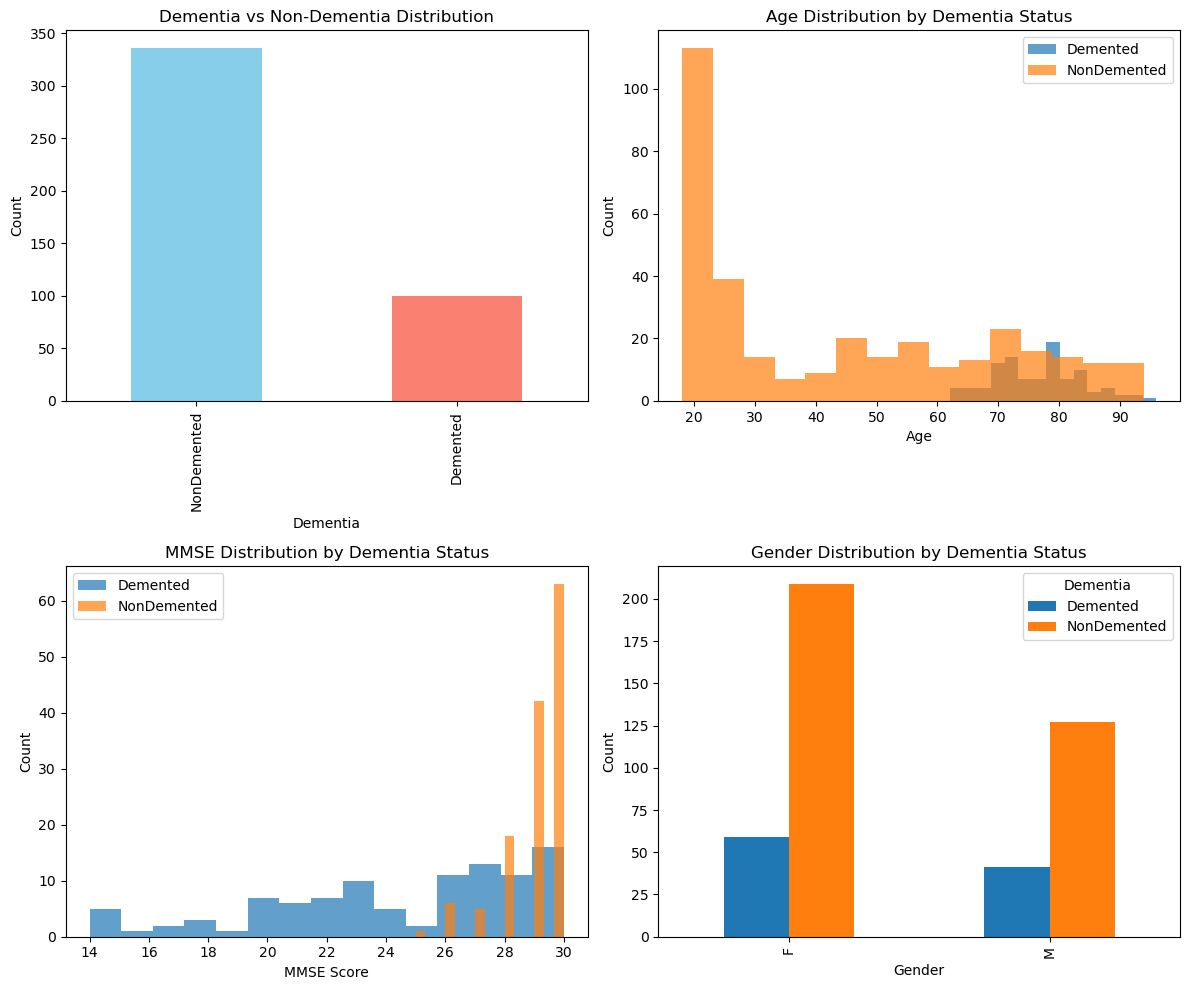

In [10]:
# 7. Visualize the data
print("\n" + "="*60)
print("DATA VISUALIZATION")
print("="*60)

# Create a 2x2 grid of plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 7.1. Class distribution
df['Dementia'].value_counts().plot(kind='bar', ax=axes[0, 0], color=['skyblue', 'salmon'])
axes[0, 0].set_title('Dementia vs Non-Dementia Distribution')
axes[0, 0].set_ylabel('Count')

# 7.2. Age distribution by dementia status
for status in ['Demented', 'NonDemented']:
    subset = df[df['Dementia'] == status]
    axes[0, 1].hist(subset['Age'], alpha=0.7, label=status, bins=15)
axes[0, 1].set_title('Age Distribution by Dementia Status')
axes[0, 1].set_xlabel('Age')
axes[0, 1].set_ylabel('Count')
axes[0, 1].legend()

# 7.3. MMSE distribution by dementia status
for status in ['Demented', 'NonDemented']:
    subset = df[df['Dementia'] == status]
    axes[1, 0].hist(subset['MMSE'], alpha=0.7, label=status, bins=15)
axes[1, 0].set_title('MMSE Distribution by Dementia Status')
axes[1, 0].set_xlabel('MMSE Score')
axes[1, 0].set_ylabel('Count')
axes[1, 0].legend()

# 7.4. Gender distribution by dementia
gender_dementia = pd.crosstab(df['Gender'], df['Dementia'])
gender_dementia.plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_title('Gender Distribution by Dementia Status')
axes[1, 1].set_ylabel('Count')

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'basic_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()



SAMPLE MRI VISUALIZATION
Loading sample MRI: mwrc1OAS1_0001_MR1_mpr_anon_fslswapdim_bet.nii.gz
Image shape: (91, 109, 91)
Image data type: float32


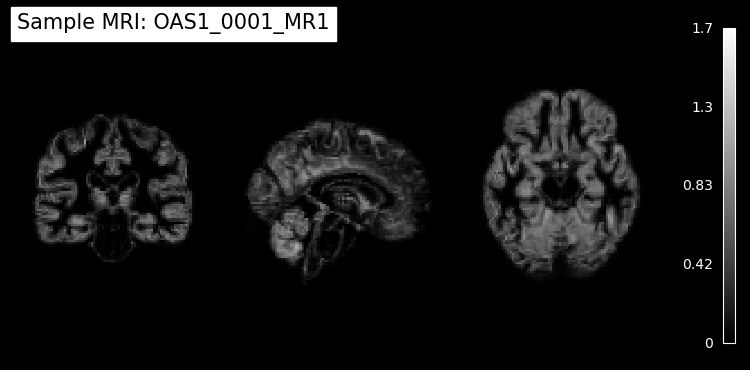

In [11]:
# 8. Load and visualize a sample MRI
print("\n" + "="*60)
print("SAMPLE MRI VISUALIZATION")
print("="*60)

# Get the first subject with MRI data
sample_subject = subject_dirs[0]
sample_path = os.path.join(OASIS_DIR, sample_subject)
mri_files = [f for f in os.listdir(sample_path) if f.startswith('mwrc1') and f.endswith('.nii.gz')]

if mri_files:
    mri_path = os.path.join(sample_path, mri_files[0])
    print(f"Loading sample MRI: {mri_files[0]}")
    
    # Load the image
    img = nib.load(mri_path)
    print(f"Image shape: {img.shape}")
    print(f"Image data type: {img.get_data_dtype()}")
    
    # Plot the image
    plotting.plot_anat(img, title=f"Sample MRI: {sample_subject}", 
                      draw_cross=False, annotate=False)
    plt.show()
else:
    print("No MRI files found in sample subject")

In [12]:
# 9. Save processed metadata
df.to_csv(os.path.join(PROCESSED_DIR, 'oasis_processed_metadata.csv'), index=False)
print(f"\nProcessed metadata saved to: {os.path.join(PROCESSED_DIR, 'oasis_processed_metadata.csv')}")

print("\n" + "="*60)
print("PHASE 1: DATA EXPLORATION COMPLETE")
print("="*60)


Processed metadata saved to: F:/Programming codes/Machine Learning/Projects/brain-disease-segmentation-benchmark\data\processed\oasis_processed_metadata.csv

PHASE 1: DATA EXPLORATION COMPLETE
